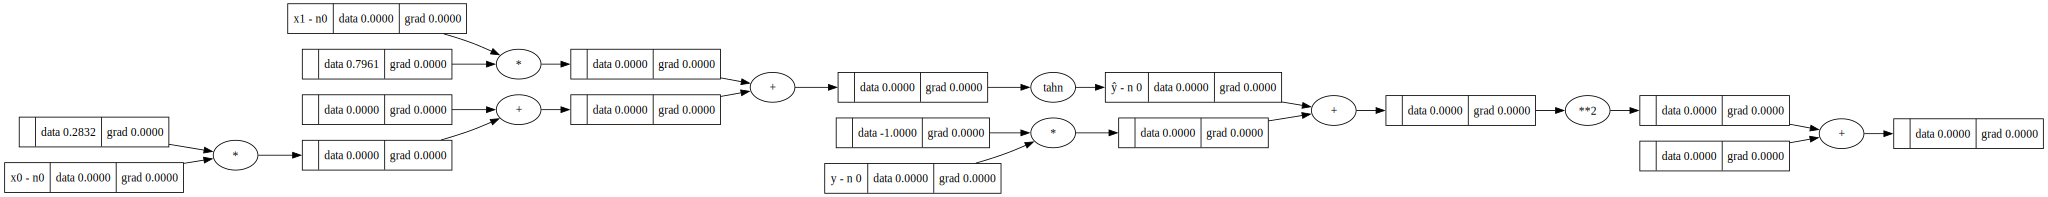

In [389]:
from michigrad.engine import Value
from michigrad.nn import Layer, NeuronType
from michigrad.visualize import show_graph

XOR = [
    ([0,0], 0),
    ([0,1], 1),
    ([1,0], 1),
    ([1,1], 0),
]

model = Layer.new_layer(2, 1, NeuronType.Tanh) # Neuronas ReLU
learning_rate = 0.05
loss = Value(0)

# forward pass
for index, (x, y) in enumerate(XOR):
    (x0, x1) = (Value(x[0]), Value(x[1]))
    x0.name = f"x0 - n{index}"
    x1.name = f"x1 - n{index}"
    y = Value(y)
    y.name = f"y - n {index}"
    x = [x0,x1]
    yhat = model(x)
    yhat.name = f"ŷ - n {index}"

    # Error Cuadrático Medio
    loss += (yhat - y)**2
    break # Romper luego del primer forward pass

show_graph(loss)

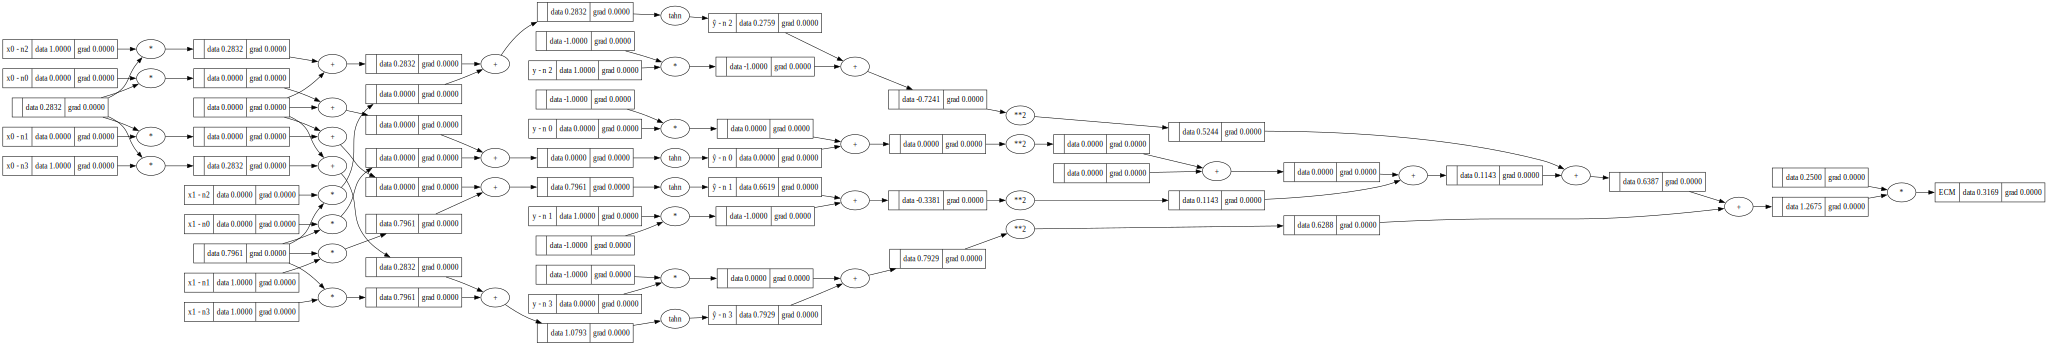

In [390]:
# forward pass (Continuación)
for index, (x, y) in enumerate(XOR):
    if index == 0:
        continue # Saltamos primer forward pass ya realizado
    (x0, x1) = (Value(x[0]), Value(x[1]))
    x0.name = f"x0 - n{index}"
    x1.name = f"x1 - n{index}"
    y = Value(y)
    y.name = f"y - n {index}"
    x = [x0,x1]
    yhat = model(x)
    yhat.name = f"ŷ - n {index}"

    # Error Cuadrático Medio
    loss += (yhat - y)**2

# 1/N * Sumatoria
loss /= len(XOR)
loss.name = "ECM"

show_graph(loss)

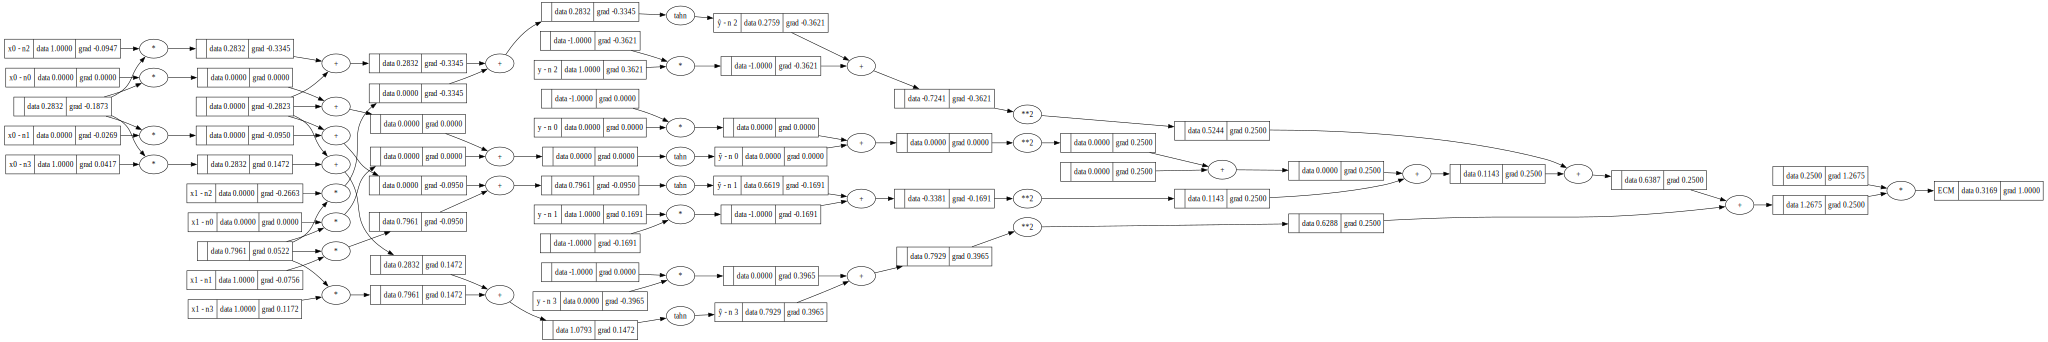

In [391]:
# Borrado de gradientes
model.zero_grad()

# Backward pass / Backpropagation
loss.backward()

show_graph(loss)

In [392]:
# Update
for p in model.parameters():
    p.data -= learning_rate * p.grad

last_loss = float("inf")
EPOCHS = 300
# Ahora se itera, comprobando que que la función de pérdida es disminuida en cada iteración.
for epoch in range(EPOCHS):
    loss = Value(0)
    
    # forward pass
    for (x, y) in XOR:
        (x0, x1) = (Value(x[0]), Value(x[1]))
        x0.name = f"x0 - n{index}"
        x1.name = f"x1 - n{index}"
        y = Value(y)
        y.name = f"y - n {index}"
        x = [x0,x1]
        yhat = model(x)
        yhat.name = f"ŷ - n {index}"
        
        # Error Cuadrático Medio
        loss += (yhat - y)**2

    loss /= len(XOR) # 1/n * sum

    # Borrado de gradientes
    model.zero_grad()
    
    # backward
    loss.backward()

    # update
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    # Recuperar el dato de las pérdidas para comparar:
    vloss = loss
    while isinstance(vloss, Value): 
        vloss = vloss.data
    if vloss == last_loss: # Sin linealidad disimuye más rápido
        print(f"La función de pérdida no disminuyó en {epoch} | {vloss} == {last_loss}")
        break
    last_loss = vloss

print(f"Pérdida final {vloss}")
print("Parametros finales:")
for p in model.parameters():
    while isinstance(p, Value):
        p = p.data
    print(p)

print("Predicciones finales:")
# forward pass
for index, (x, y) in enumerate(XOR):
    (x0, x1) = (x[0],x[1])
    x = [x0,x1]
    yhat = model(x)

    while isinstance(yhat, Value):
        yhat = yhat.data
    
    print(f"{x0} XOR {x1} = {y} | Predicción: {yhat}")

Pérdida final 0.26194952178320835
Parametros finales:
0.5585734773906952
0.5638947042677417
0.2084104443899846
Predicciones finales:
0 XOR 0 = 0 | Predicción: 0.20544453352198513
0 XOR 1 = 1 | Predicción: 0.6482678552615277
1 XOR 0 = 1 | Predicción: 0.6451722310432875
1 XOR 1 = 0 | Predicción: 0.8694639103351083


# Explicación

El modelo no logra representar la función correctamente debido al mismo motivo que una función de activación lineal tampoco logra representar la función correctamente.

Visualmente, la tangente hiperbólica forma una "S" plana, ReLU forma una linea donde para x<0 asigna 0, y la curva logística (sigmoide) es similar a una tangente hiperbólica que no devuelve valores menores a 0. XOR se representaría en el plano de la siguiente manera:
- En las posiciones (0,0) y (1,1) tendría valor 0.
- En las posiciones (0,1) y (1,0) tendría valor 1.

Si quisieramos trazar una Linea única para separar estos vectores (Considerando que, al ser todas funciones no pueden poseer múltiples valores), no tendríamos forma de tomar las regiones donde y=0 e y=1 pues el corte dejaría (en el mejor caso), al menos un valor del lado contrario al de su clase. No podría haber un corte adecuado, tal como ocurre con la función de activación lineal.